In [1]:

#%% 
# Data importing and Loading
import numpy as np
import torch
import torchvision 
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets
from torchvision import transforms
from torch import nn, optim
import functools
import PIL
from torchvision import transforms as T
import pytorch_lightning as pl

# To obtain the dataset from the drive and transform it
transforms = T.Compose([T.ToTensor(),T.Resize([244,244])])
image_root=r"C:\Users\Admin\OneDrive - Nanyang Technological University\FYP\Dataset_BUSI_with_GT"

Mdataset = torchvision.datasets.ImageFolder(root=image_root, transform=transforms)#, target_transform=target_transforms)

#Mdataset[0]


In [2]:
# Defining datasets
torch.manual_seed(1)  #Seeding is to keep random numbers the same to prevent overfitting
trainset, validset, testset =torch.utils.data.random_split(Mdataset,[int(len(Mdataset)*0.8), int(len(Mdataset)*0.1), int(len(Mdataset)*0.1)])
batch_size=2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle= False)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle= False) 

# Visualization on how tensor data in data_loader works 
for x, y in train_loader:   # x= input y=label
  print(x)
#  print(y)
  #print(x.shape)
  #print(y.shape)
  break

tensor([[[[0.0499, 0.0120, 0.3124,  ..., 0.4012, 0.4194, 0.4441],
          [0.4946, 0.2644, 0.4060,  ..., 0.5416, 0.5797, 0.6041],
          [0.8403, 0.3721, 0.3659,  ..., 0.6191, 0.5661, 0.4400],
          ...,
          [0.1028, 0.1021, 0.1032,  ..., 0.1047, 0.1016, 0.0959],
          [0.1154, 0.1059, 0.1037,  ..., 0.1278, 0.1273, 0.1218],
          [0.0902, 0.0894, 0.1012,  ..., 0.1110, 0.1139, 0.1100]],

         [[0.0499, 0.0120, 0.3124,  ..., 0.4012, 0.4194, 0.4441],
          [0.4946, 0.2644, 0.4060,  ..., 0.5416, 0.5797, 0.6041],
          [0.8403, 0.3721, 0.3659,  ..., 0.6191, 0.5661, 0.4400],
          ...,
          [0.1028, 0.1021, 0.1032,  ..., 0.1047, 0.1016, 0.0959],
          [0.1154, 0.1059, 0.1037,  ..., 0.1278, 0.1273, 0.1218],
          [0.0902, 0.0894, 0.1012,  ..., 0.1110, 0.1139, 0.1100]],

         [[0.0499, 0.0120, 0.3124,  ..., 0.4012, 0.4194, 0.4441],
          [0.4946, 0.2644, 0.4060,  ..., 0.5416, 0.5797, 0.6041],
          [0.8403, 0.3721, 0.3659,  ..., 0

In [3]:
# Defining Models and classes
import warnings
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch import    nn,Tensor
from torchvision.models import resnet18, resnet50, alexnet, vgg16, vgg16_bn, mobilenet_v2,inception_v3
from collections import namedtuple
from typing import Callable, Any, Optional, Tuple, List
import torch.nn.functional as F

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',    #BN is batch normalization (used for fyp to illustrate how BN affects the results)
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
    'inception_v3': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
    }
#   INCEPTION
InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])
InceptionOutputs.__annotations__ = {'logits': Tensor, 'aux_logits': Optional[Tensor]}
_InceptionOutputs = InceptionOutputs
class Inception3(pl.LightningModule):

    def __init__(
        self,
        num_classes: int = 1000,
        aux_logits: bool = True,
        transform_input: bool = False,
        inception_blocks: Optional[List[Callable[..., nn.Module]]] = None,
        init_weights: Optional[bool] = None
    ) -> None:
        super(Inception3, self).__init__()
        if inception_blocks is None:
            inception_blocks = [
                BasicConv2d, InceptionA, InceptionB, InceptionC,
                InceptionD, InceptionE, InceptionAux
            ]
        if init_weights is None:
            warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
                          'torchvision. If you wish to keep the old behavior (which leads to long initialization times'
                          ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
            init_weights = True
        assert len(inception_blocks) == 7
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]
        inception_b = inception_blocks[2]
        inception_c = inception_blocks[3]
        inception_d = inception_blocks[4]
        inception_e = inception_blocks[5]
        inception_aux = inception_blocks[6]

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)
        self.AuxLogits: Optional[nn.Module] = None
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048, num_classes)
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    import scipy.stats as stats
                    stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                    X = stats.truncnorm(-2, 2, scale=stddev)
                    values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                    values = values.view(m.weight.size())
                    with torch.no_grad():
                        m.weight.copy_(values)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _transform_input(self, x: Tensor) -> Tensor:
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux: Optional[Tensor] = None
        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

    @torch.jit.unused
    def eager_outputs(self, x: Tensor, aux: Optional[Tensor]) -> InceptionOutputs:
        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)
        else:
            return x  # type: ignore[return-value]

    def forward(self, x: Tensor) -> InceptionOutputs:
        x = self._transform_input(x)
        x, aux = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted Inception3 always returns Inception3 Tuple")
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)
class InceptionA(pl.LightningModule):

    def __init__(
        self,
        in_channels: int,
        pool_features: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionA, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)
class InceptionB(pl.LightningModule):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionB, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)
class InceptionC(pl.LightningModule):

    def __init__(
        self,
        in_channels: int,
        channels_7x7: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionC, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)
class InceptionD(pl.LightningModule):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionD, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)
class InceptionE(pl.LightningModule):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionE, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)
class InceptionAux(pl.LightningModule):

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01  # type: ignore[assignment]
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001  # type: ignore[assignment]

    def forward(self, x: Tensor) -> Tensor:
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x
class BasicConv2d(pl.LightningModule):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

#   MOBILENET
def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
class ConvBNActivation(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        activation_layer: Optional[Callable[..., nn.Module]] = None,
        dilation: int = 1,
    ) -> None:
        padding = (kernel_size - 1) // 2 * dilation
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = nn.ReLU6
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation=dilation, groups=groups,
                      bias=False),
            norm_layer(out_planes),
            activation_layer(inplace=True)
        )
        self.out_channels = out_planes
# necessary for backwards compatibility
ConvBNReLU = ConvBNActivation
class InvertedResidual(pl.LightningModule):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)
class MobileNetV2(pl.LightningModule):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use

        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)
def mobilenet_v2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV2:
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model
#   RESNET
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
class BasicBlock(pl.LightningModule):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[pl.LightningModule] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., pl.LightningModule]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class Bottleneck(pl.LightningModule):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[pl.LightningModule] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., pl.LightningModule]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class ResNet(pl.LightningModule):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model
def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)
def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


#   ALEXNET
class AlexNet(pl.LightningModule):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
def alexnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> AlexNet:
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model
#   VGG
class VGG(pl.LightningModule):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


In [4]:
# Defining Test model
def test_f1(model,lr): 
    optimizer = optim.Adam(model.parameters(), lr=1e-04)  
    criterion = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
      model,criterion = model.cuda(),criterion.cuda()

    checkpoint = torch.load("highest_f1.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    f1 = checkpoint['f1']
    print ("\nepoch{} has the highest f1 score of {}".format(epoch,f1))
    
    true_test=[]
    pred_test=[]
    true_test_cat=[]
    pred_test_cat=[]

    test_loss =0
    test_running_corrects=0

    test_dataiter= iter(test_loader)
    x_test,y_test=test_dataiter.next()

    with torch.no_grad():
      model.eval()
      for x_test,y_test in test_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            x_test,y_test =x_test.cuda(),y_test.cuda()
        test_output= model(x_test)
        tes_loss= criterion(test_output,y_test) 
        test_loss += tes_loss.item()

        #_,z= output.max(1)
        #print(output.shape)
        _,z_test  = test_output.max(1)
        test_running_corrects += torch.sum(y_test == z_test)

        true_numpy= y_test.cpu().detach().numpy()
        true_test.append(true_numpy)
        
        pred_numpy= z_test.cpu().detach().numpy()
        pred_test.append(pred_numpy)
      else: #end of for loop testset
      #print(true_test)
        true_test_cat= np.concatenate(true_test)
        pred_test_cat= np.concatenate(pred_test)
        f1_test= f1_score(true_test_cat,pred_test_cat, average = 'weighted')           
        file = open(r'{}_results\data_results.txt'.format(lr), 'a')
        file.write("highest_f1 test//test_loss:{:.3f}      test_acc:{:.2f}%    test_f1: {:.3f}\n".format(test_loss/len(test_loader),100*test_running_corrects/len(testset), f1_test))
        file.close()       
 

def test_valid(model,lr): 
    optimizer = optim.Adam(model.parameters(), lr=1e-04)  
    criterion = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
      model,criterion = model.cuda(),criterion.cuda()    

    checkpoint = torch.load("smallest_valid_loss.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    v_loss = checkpoint['v_loss']
    batch = checkpoint['batch']
    print ("\nepoch{} of iteration {} has the smallest valid loss of {}".format(epoch,batch,v_loss))
  
    true_test=[]
    pred_test=[]
    true_test_cat=[]
    pred_test_cat=[]

    test_loss =0
    test_running_corrects=0

    test_dataiter= iter(test_loader)
    x_test,y_test=test_dataiter.next()

    with torch.no_grad():
      model.eval()
      for x_test,y_test in test_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            x_test,y_test =x_test.cuda(),y_test.cuda()
        test_output= model(x_test)
        tes_loss= criterion(test_output,y_test) 
        test_loss += tes_loss.item()

        #_,z= output.max(1)
        #print(output.shape)
        _,z_test  = test_output.max(1)
        test_running_corrects += torch.sum(y_test == z_test)

        true_numpy= y_test.cpu().detach().numpy()
        true_test.append(true_numpy)
        
        pred_numpy= z_test.cpu().detach().numpy()
        pred_test.append(pred_numpy)
      else: #end of for loop testset
      #print(true_test)
        true_test_cat= np.concatenate(true_test)
        pred_test_cat= np.concatenate(pred_test)
        f1_test= f1_score(true_test_cat,pred_test_cat, average = 'weighted')           
        file = open(r'{}_results\data_results.txt'.format(lr), 'a')
        file.write("smallest_valid_test//test_loss:{:.3f}      test_acc:{:.2f}%    test_f1: {:.2f}\n".format(test_loss/len(test_loader),100*test_running_corrects/len(testset), f1_test))
        file.close()                  


In [5]:
def graph(counter,title,value1,lr,xlabel):
    plt.figure(counter)
    plt.plot(value1,label=title)
    #plt.plot(value2,label=label2)
    plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    plt.legend()
    plt.title(lr)
    if not os.path.exists("{}_results".format(lr)):
        os.mkdir("{}_results".format(lr))
    plt.savefig(r"{}_results\{}_{}.png".format(lr,lr,title)) 
    plt.show()

def lrgraph(counter,title,value0,value1,value2,value3,
                             lr0,lr1,lr2,lr3,xlabel):
    plt.figure(counter)
    plt.title(title)
    plt.plot(value0,label=lr0, linestyle='solid')
    plt.plot(value1,label=lr1, linestyle='dashed')
    plt.plot(value2,label=lr2, linestyle='dotted')
    plt.plot(value3,label=lr3, linestyle='dashdot')
    plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    #plt.plot(value4,label=lr4, color=color4)  
    plt.legend()
    plt.savefig(r"{}_lr_combined.png".format(title)) 
    plt.show()

def modelgraph(counter,title,value1,value2,value3,
                             lr1,lr2,lr3,xlabel):
    plt.figure(counter)
    plt.title(title)
    plt.plot(value1,label=lr1, linestyle='solid')
    plt.plot(value2,label=lr2, linestyle='dashed')
    plt.plot(value3,label=lr3, linestyle='dotted')
    plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(r"{}_model_combined.png".format(title)) 
    plt.show()


def mean(x,label,lr):
  if torch.is_tensor(x[0]):
    cat=torch.stack(x).cpu().detach().numpy() #convert to numpy list
    mean(cat,label,lr)
  else:
    #print("beforemath",x)
    if not os.path.exists("{}_results".format(lr)):
        os.mkdir("{}_results".format(lr))
    np.save(r'{}_results\{}_{}.npy'.format(lr,lr,label),x)
    mean_value = np.mean(x)
    stdev_value = np.std(x)    
    print("{}   mean:{:.2f}     stdev:{:.2f}".format(label,mean_value,stdev_value))
    file = open(r'{}_results\data_results.txt'.format(lr), 'a')
    file.write("{}   mean:{:.2f}     stdev:{:.2f}\n".format(label,mean_value,stdev_value))
    file.close()


In [6]:
# Defining Training model
from sklearn.metrics import f1_score
import os
import math
import statistics


def training(model,lr):
  
  optimizer = optim.Adam(model.parameters(), lr=lr)  
  criterion = nn.CrossEntropyLoss()
  if torch.cuda.is_available():
    model = model.cuda()    
    criterion = criterion.cuda()

  train_loss_values =[]
  train_acc_values =[]
  train_f1_values=[]

  valid_loss_values =[]
  valid_acc_values =[]
  valid_f1_values= []

  smallest_valid_loss = 10
  highest_f1 =0
  epoch = 50
  print("Learning rate", lr)
  print("Total runable epoch i:",epoch) 
  print("Total runable iteration j:", epoch*len(train_loader))

  for i in range(epoch):
  # Training loop
 
    train_loss = 0
    train_running_corrects=0
    true_train = []
    pred_train =[]
    true_train_cat =[]
    pred_train_cat= []
    
    train_dataiter= iter(train_loader)
    x_train,y_train=train_dataiter.next()
    model.train()

    for j, (x_train,y_train)in enumerate(train_loader):
      #print("iteration:{} of {}".format(j+1,epoch*len(train_loader)))

      optimizer.zero_grad() 
      x,y=x_train,y_train
      if torch.cuda.is_available():
        x,y=x_train.cuda(),y_train.cuda()

      train_output = model(x)
      trn_loss = criterion(train_output,y)  
      trn_loss.backward() #backpropagate for model to learn
      optimizer.step()      #teach the data to learn the new sets
      train_loss +=trn_loss.item()  #to obtain loss

      _,z= train_output.max(1)    #to obtain acc
      train_running_corrects += torch.sum(y == z)

      true_numpy= y.cpu().detach().numpy()  #to obtain f1
      true_train.append(true_numpy)
      pred_numpy= z.cpu().detach().numpy()
      pred_train.append(pred_numpy)

      if (j%10 ==0):
          valid_loss = 0 
          valid_running_corrects=0
          true_valid = []
          pred_valid = []
          true_valid_cat  = []
          pred_valid_cat = [] 
          
          with torch.no_grad():     #Set all required grad flag to be false

            model.eval()
            for x_valid,y_valid in valid_loader:
              x,y= x_valid, y_valid
              if torch.cuda.is_available(): 
                x,y=x_valid.cuda(),y_valid.cuda()

              valid_output = model(x)     #to obtain loss
              val_loss = criterion(valid_output,y)
              valid_loss +=val_loss.item()
            
              _,z= valid_output.max(1)    #to obtain acc
              valid_running_corrects += torch.sum(y == z)
              
              true_numpy= y.cpu().detach().numpy()  #to obtain f1
              true_valid.append(true_numpy)
              pred_numpy= z.cpu().detach().numpy()
              pred_valid.append(pred_numpy)
            else: # end of for loop validset
              true_valid_cat= np.concatenate(true_valid)  #convert from tensor to numpy for f1 scoring
              pred_valid_cat= np.concatenate(pred_valid)  
              v_f1=f1_score(true_valid_cat,pred_valid_cat, average = 'weighted')
              if (v_f1 > highest_f1):
                 if os.path.exists("highest_f1.pt"):
                   os.remove("highest_f1.pt")
                 highest_f1=v_f1
                 torch.save({'epoch': i+1,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'f1': highest_f1
                        },r"highest_f1.pt")
              valid_f1_values.append(v_f1)              
                          
              v_loss=valid_loss/len(valid_loader)
              if (v_loss < smallest_valid_loss):
                    if os.path.exists("smallest_valid_loss.pt"):
                        os.remove("smallest_valid_loss.pt")               
                    smallest_valid_loss=v_loss
                    torch.save({'epoch': i+1,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'v_loss': smallest_valid_loss,
                                'batch': j+1
                            },r"smallest_valid_loss.pt")
              valid_loss_values.append(v_loss)  

              v_acc=100*valid_running_corrects/len(validset)
              valid_acc_values.append(v_acc)

    else: #end of for loop trainset (j loop)

      true_train_cat= np.concatenate(true_train)
      pred_train_cat= np.concatenate(pred_train)
      tn_f1=f1_score(true_train_cat,pred_train_cat, average = 'weighted')
      train_f1_values.append(tn_f1)   

      tn_loss=train_loss/len(train_loader)
      train_loss_values.append((tn_loss))

      tn_acc=100*train_running_corrects/len(trainset)
      train_acc_values.append(tn_acc)
      #print("epoch: {}/{}".format(i,epoch))
      print("epoch: {}/{} tn_loss:{:.3f}  tn_acc:{:.2f}% tn_f1:{:.3f} v_loss: {:.3f}   v_acc:{:.2f}%  v_f1:{:.3f}".format(i+1,epoch,tn_loss, tn_acc, tn_f1,v_loss, v_acc, v_f1))

  else: #end of training (epoch=i loop)

        graph(1,'trainacc',train_acc_values,lr,"epoch i")
        graph(2,'validacc',valid_acc_values,lr,"iterations j")
        graph(3,'trainf1',train_f1_values,lr,"epoch i")
        graph(4,'validf1',valid_f1_values,lr,"iterations j")
        graph(5,'trainloss',train_loss_values,lr,"epoch i")
        graph(6,'validloss',valid_loss_values,lr,"iterations j")
        
        cwd=os.getcwd()
        file = open(r'{}_results\data_results.txt'.format(lr), 'w')
        file.write(cwd)
        file.close()
           
        mean(train_loss_values,"trainloss",lr)
        mean(train_acc_values,"trainacc",lr)
        mean(train_f1_values, "trainf1",lr)
        mean(valid_loss_values,"validloss",lr)
        mean(valid_acc_values,"validacc",lr)
        mean(valid_f1_values, "validf1",lr)
        test_valid(model,lr)
        test_f1(model,lr)  

In [7]:
# Defining lr
lr0=1e-03
lr1=1e-05
lr2=1e-07
lr3=1e-09

Learning rate 0.001
Total runable epoch i: 50
Total runable iteration j: 15600
epoch: 1/50 tn_loss:1.062  tn_acc:55.77% tn_f1:0.401 v_loss: 0.954   v_acc:61.54%  v_f1:0.469
epoch: 2/50 tn_loss:1.201  tn_acc:52.88% tn_f1:0.406 v_loss: 1.012   v_acc:61.54%  v_f1:0.469
epoch: 3/50 tn_loss:1.036  tn_acc:55.13% tn_f1:0.398 v_loss: 0.936   v_acc:61.54%  v_f1:0.469
epoch: 4/50 tn_loss:1.001  tn_acc:55.61% tn_f1:0.397 v_loss: 0.918   v_acc:61.54%  v_f1:0.469
epoch: 5/50 tn_loss:0.996  tn_acc:55.61% tn_f1:0.397 v_loss: 0.929   v_acc:61.54%  v_f1:0.469
epoch: 6/50 tn_loss:0.997  tn_acc:55.61% tn_f1:0.397 v_loss: 0.970   v_acc:61.54%  v_f1:0.469
epoch: 7/50 tn_loss:1.015  tn_acc:56.09% tn_f1:0.428 v_loss: 0.919   v_acc:61.54%  v_f1:0.469
epoch: 8/50 tn_loss:0.999  tn_acc:55.77% tn_f1:0.401 v_loss: 0.969   v_acc:61.54%  v_f1:0.469
epoch: 9/50 tn_loss:1.009  tn_acc:55.61% tn_f1:0.400 v_loss: 0.936   v_acc:61.54%  v_f1:0.469
epoch: 10/50 tn_loss:0.991  tn_acc:55.77% tn_f1:0.404 v_loss: 0.928   v_acc

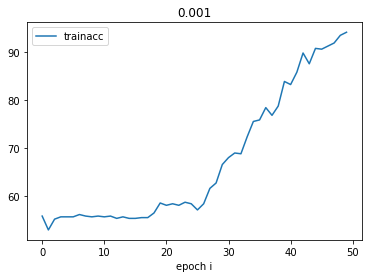

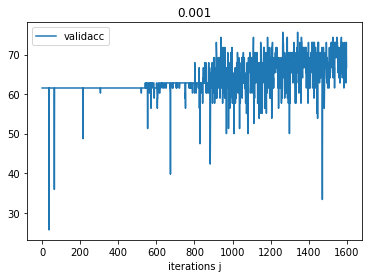

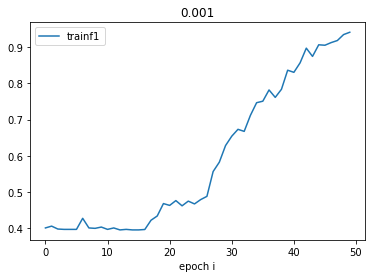

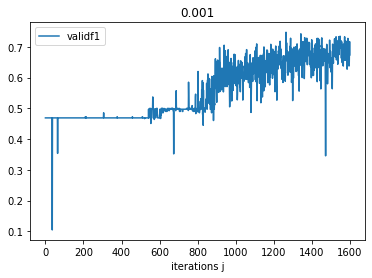

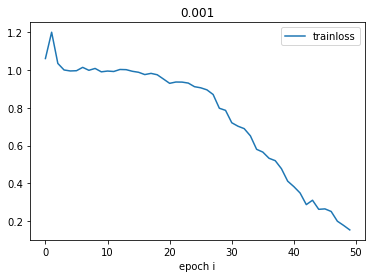

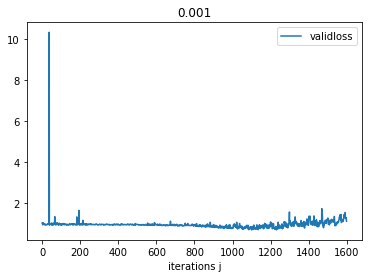

trainloss   mean:0.75     stdev:0.30
trainacc   mean:67.09     stdev:13.67
trainf1   mean:0.59     stdev:0.20
validloss   mean:0.92     stdev:0.26
validacc   mean:63.55     stdev:4.16
validf1   mean:0.55     stdev:0.09

epoch35 of iteration 131 has the smallest valid loss of 0.6663416192691679

epoch40 has the highest f1 score of 0.7472993355346297


In [8]:
#RESNET18 lr0
torch.manual_seed(1)
model = resnet18(num_classes=3) #there are 3 classes:RGB
model_path=r"C:\Users\Admin\Documents\FYP\RESNET18"
if not os.path.exists(model_path):
    os.mkdir(model_path)
os.chdir(model_path)
training(model,lr0)

Learning rate 1e-05
Total runable epoch i: 50
Total runable iteration j: 15600
epoch: 1/50 tn_loss:0.990  tn_acc:55.13% tn_f1:0.404 v_loss: 0.914   v_acc:61.54%  v_f1:0.469
epoch: 2/50 tn_loss:0.984  tn_acc:54.97% tn_f1:0.404 v_loss: 0.936   v_acc:61.54%  v_f1:0.469
epoch: 3/50 tn_loss:0.995  tn_acc:54.17% tn_f1:0.414 v_loss: 0.906   v_acc:61.54%  v_f1:0.493
epoch: 4/50 tn_loss:0.976  tn_acc:54.65% tn_f1:0.412 v_loss: 0.862   v_acc:61.54%  v_f1:0.473
epoch: 5/50 tn_loss:0.959  tn_acc:56.89% tn_f1:0.467 v_loss: 0.858   v_acc:61.54%  v_f1:0.469
epoch: 6/50 tn_loss:0.924  tn_acc:58.97% tn_f1:0.499 v_loss: 0.918   v_acc:67.95%  v_f1:0.638
epoch: 7/50 tn_loss:0.928  tn_acc:58.17% tn_f1:0.509 v_loss: 0.856   v_acc:70.51%  v_f1:0.662
epoch: 8/50 tn_loss:0.877  tn_acc:60.58% tn_f1:0.533 v_loss: 0.897   v_acc:61.54%  v_f1:0.625
epoch: 9/50 tn_loss:0.854  tn_acc:62.34% tn_f1:0.563 v_loss: 0.804   v_acc:64.10%  v_f1:0.568
epoch: 10/50 tn_loss:0.814  tn_acc:66.51% tn_f1:0.628 v_loss: 0.852   v_acc

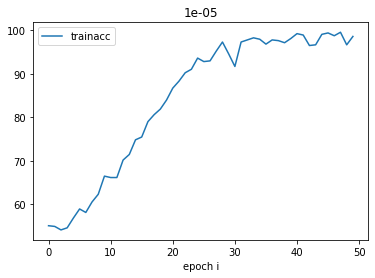

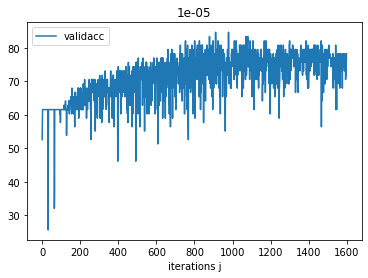

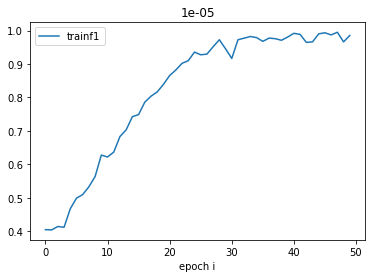

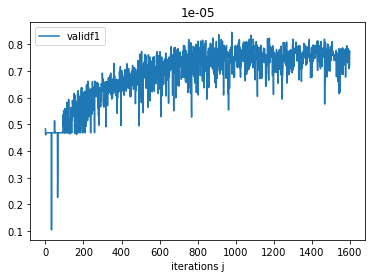

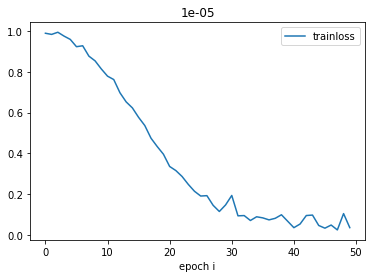

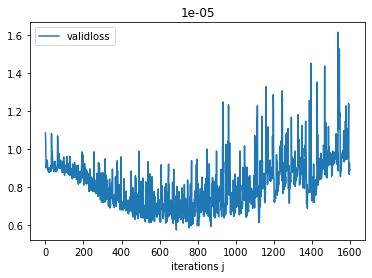

trainloss   mean:0.38     stdev:0.34
trainacc   mean:84.16     stdev:15.83
trainf1   mean:0.82     stdev:0.20
validloss   mean:0.81     stdev:0.13
validacc   mean:71.43     stdev:6.57
validf1   mean:0.69     stdev:0.10

epoch22 of iteration 161 has the smallest valid loss of 0.5744250727883087

epoch31 has the highest f1 score of 0.8454940504629945


In [9]:
#RESNET18 lr1
torch.manual_seed(1)
model = resnet18(num_classes=3) #there are 3 classes:RGB
training(model,lr1)

Learning rate 1e-07
Total runable epoch i: 50
Total runable iteration j: 15600
epoch: 1/50 tn_loss:1.079  tn_acc:54.65% tn_f1:0.422 v_loss: 1.063   v_acc:61.54%  v_f1:0.469
epoch: 2/50 tn_loss:1.056  tn_acc:55.61% tn_f1:0.398 v_loss: 1.023   v_acc:61.54%  v_f1:0.469
epoch: 3/50 tn_loss:1.027  tn_acc:55.61% tn_f1:0.397 v_loss: 0.980   v_acc:61.54%  v_f1:0.469
epoch: 4/50 tn_loss:1.005  tn_acc:55.61% tn_f1:0.397 v_loss: 0.950   v_acc:61.54%  v_f1:0.469
epoch: 5/50 tn_loss:0.994  tn_acc:55.61% tn_f1:0.397 v_loss: 0.935   v_acc:61.54%  v_f1:0.469
epoch: 6/50 tn_loss:0.987  tn_acc:55.61% tn_f1:0.397 v_loss: 0.923   v_acc:61.54%  v_f1:0.469
epoch: 7/50 tn_loss:0.985  tn_acc:55.61% tn_f1:0.397 v_loss: 0.919   v_acc:61.54%  v_f1:0.469
epoch: 8/50 tn_loss:0.982  tn_acc:55.61% tn_f1:0.397 v_loss: 0.915   v_acc:61.54%  v_f1:0.469
epoch: 9/50 tn_loss:0.981  tn_acc:55.77% tn_f1:0.401 v_loss: 0.914   v_acc:61.54%  v_f1:0.469
epoch: 10/50 tn_loss:0.981  tn_acc:55.61% tn_f1:0.397 v_loss: 0.912   v_acc

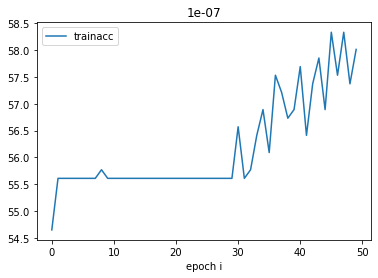

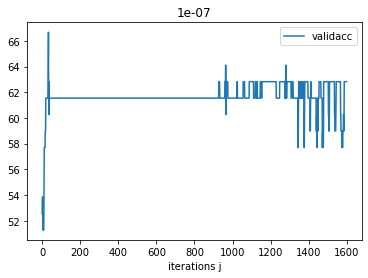

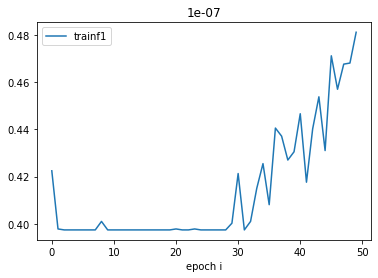

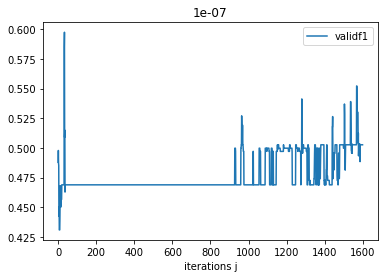

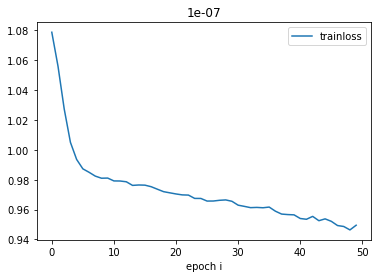

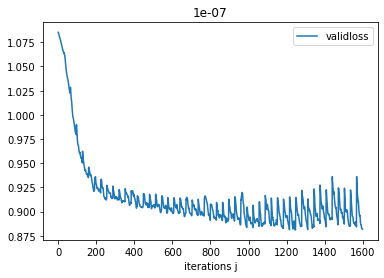

trainloss   mean:0.97     stdev:0.02
trainacc   mean:56.18     stdev:0.89
trainf1   mean:0.41     stdev:0.02
validloss   mean:0.91     stdev:0.04
validacc   mean:61.65     stdev:1.10
validf1   mean:0.48     stdev:0.02

epoch39 of iteration 311 has the smallest valid loss of 0.8810795606710972

epoch2 has the highest f1 score of 0.597403531484878


In [10]:
#RESNET18 lr2
torch.manual_seed(1)
model = resnet18(num_classes=3) #there are 3 classes:RGB
training(model,lr2)

Learning rate 1e-09
Total runable epoch i: 50
Total runable iteration j: 15600
epoch: 1/50 tn_loss:1.087  tn_acc:48.88% tn_f1:0.426 v_loss: 1.085   v_acc:53.85%  v_f1:0.498
epoch: 2/50 tn_loss:1.079  tn_acc:50.00% tn_f1:0.465 v_loss: 1.073   v_acc:52.56%  v_f1:0.508
epoch: 3/50 tn_loss:1.081  tn_acc:28.37% tn_f1:0.156 v_loss: 1.074   v_acc:29.49%  v_f1:0.180
epoch: 4/50 tn_loss:1.080  tn_acc:27.24% tn_f1:0.123 v_loss: 1.073   v_acc:25.64%  v_f1:0.105
epoch: 5/50 tn_loss:1.084  tn_acc:27.08% tn_f1:0.120 v_loss: 1.077   v_acc:25.64%  v_f1:0.105
epoch: 6/50 tn_loss:1.085  tn_acc:27.08% tn_f1:0.120 v_loss: 1.076   v_acc:25.64%  v_f1:0.105
epoch: 7/50 tn_loss:1.090  tn_acc:27.08% tn_f1:0.120 v_loss: 1.081   v_acc:25.64%  v_f1:0.105
epoch: 8/50 tn_loss:1.102  tn_acc:26.60% tn_f1:0.113 v_loss: 1.092   v_acc:25.64%  v_f1:0.105
epoch: 9/50 tn_loss:1.098  tn_acc:26.76% tn_f1:0.116 v_loss: 1.086   v_acc:25.64%  v_f1:0.105
epoch: 10/50 tn_loss:1.097  tn_acc:27.08% tn_f1:0.120 v_loss: 1.085   v_acc

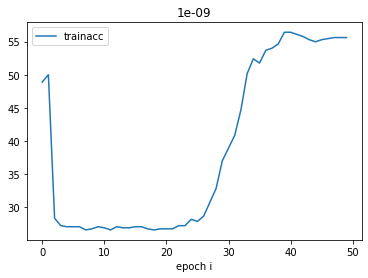

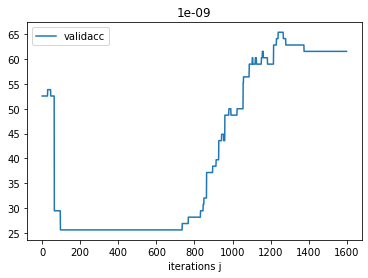

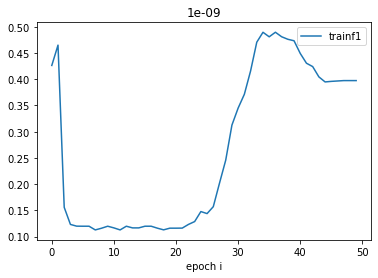

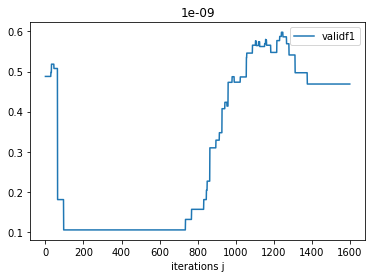

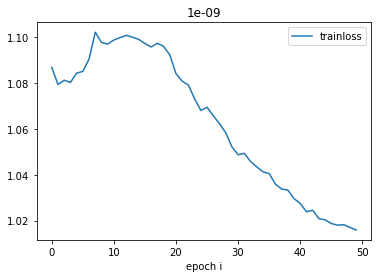

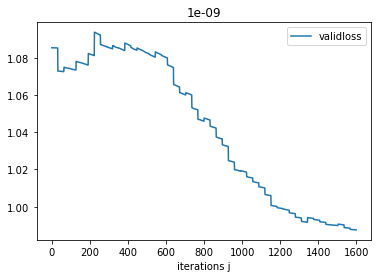

trainloss   mean:1.06     stdev:0.03
trainacc   mean:38.64     stdev:12.72
trainf1   mean:0.27     stdev:0.15
validloss   mean:1.04     stdev:0.04
validacc   mean:41.45     stdev:16.16
validf1   mean:0.30     stdev:0.19

epoch50 of iteration 311 has the smallest valid loss of 0.9875083046081738

epoch39 has the highest f1 score of 0.5981351981351981


In [11]:
#RESNET18 lr3
torch.manual_seed(1)
model = resnet18(num_classes=3) #there are 3 classes:RGB
training(model,lr3)


In [12]:
#RESNET50 lr1
torch.manual_seed(1)
model=resnet50(num_classes=3)
model_path=r"C:\Users\Admin\Documents\FYP\RESNET50"
if not os.path.exists(model_path):
    os.mkdir(model_path)
os.chdir(model_path)
training(model,lr1)


Learning rate 1e-05
Total runable epoch i: 50
Total runable iteration j: 15600
epoch: 1/50 tn_loss:1.003  tn_acc:54.33% tn_f1:0.398 v_loss: 0.930   v_acc:61.54%  v_f1:0.469
epoch: 2/50 tn_loss:0.995  tn_acc:55.29% tn_f1:0.396 v_loss: 0.928   v_acc:61.54%  v_f1:0.469
epoch: 3/50 tn_loss:0.994  tn_acc:55.45% tn_f1:0.429 v_loss: 0.918   v_acc:61.54%  v_f1:0.469
epoch: 4/50 tn_loss:0.975  tn_acc:55.29% tn_f1:0.413 v_loss: 0.950   v_acc:61.54%  v_f1:0.469
epoch: 5/50 tn_loss:0.978  tn_acc:55.61% tn_f1:0.444 v_loss: 0.918   v_acc:62.82%  v_f1:0.531
epoch: 6/50 tn_loss:0.977  tn_acc:56.09% tn_f1:0.452 v_loss: 0.856   v_acc:60.26%  v_f1:0.463
epoch: 7/50 tn_loss:0.953  tn_acc:56.73% tn_f1:0.470 v_loss: 0.894   v_acc:61.54%  v_f1:0.584
epoch: 8/50 tn_loss:0.924  tn_acc:58.97% tn_f1:0.504 v_loss: 0.817   v_acc:66.67%  v_f1:0.604
epoch: 9/50 tn_loss:0.928  tn_acc:60.10% tn_f1:0.535 v_loss: 1.089   v_acc:29.49%  v_f1:0.298
epoch: 10/50 tn_loss:0.935  tn_acc:58.01% tn_f1:0.511 v_loss: 0.840   v_acc

Learning rate 1e-05
Total runable epoch i: 50
Total runable iteration j: 15600
epoch: 1/50 tn_loss:0.992  tn_acc:55.77% tn_f1:0.401 v_loss: 0.923   v_acc:61.54%  v_f1:0.469
epoch: 2/50 tn_loss:0.970  tn_acc:55.61% tn_f1:0.397 v_loss: 0.859   v_acc:61.54%  v_f1:0.469
epoch: 3/50 tn_loss:0.941  tn_acc:55.61% tn_f1:0.409 v_loss: 0.875   v_acc:62.82%  v_f1:0.541
epoch: 4/50 tn_loss:0.891  tn_acc:60.74% tn_f1:0.529 v_loss: 0.819   v_acc:69.23%  v_f1:0.647
epoch: 5/50 tn_loss:0.833  tn_acc:64.10% tn_f1:0.574 v_loss: 0.760   v_acc:71.79%  v_f1:0.660
epoch: 6/50 tn_loss:0.810  tn_acc:66.83% tn_f1:0.600 v_loss: 0.725   v_acc:69.23%  v_f1:0.635
epoch: 7/50 tn_loss:0.747  tn_acc:65.54% tn_f1:0.589 v_loss: 0.698   v_acc:70.51%  v_f1:0.658
epoch: 8/50 tn_loss:0.704  tn_acc:67.31% tn_f1:0.627 v_loss: 0.680   v_acc:69.23%  v_f1:0.661
epoch: 9/50 tn_loss:0.679  tn_acc:69.23% tn_f1:0.670 v_loss: 0.672   v_acc:67.95%  v_f1:0.651
epoch: 10/50 tn_loss:0.614  tn_acc:72.44% tn_f1:0.713 v_loss: 0.650   v_acc

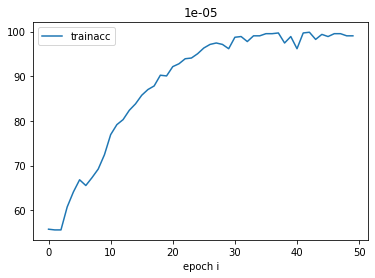

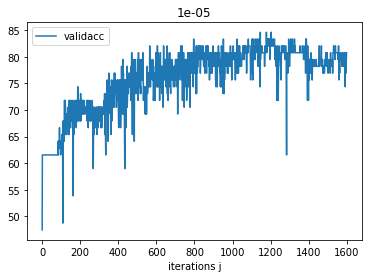

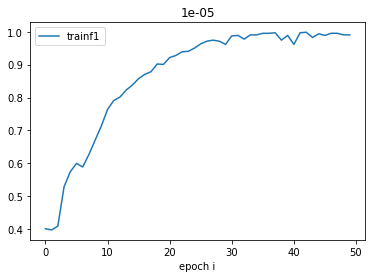

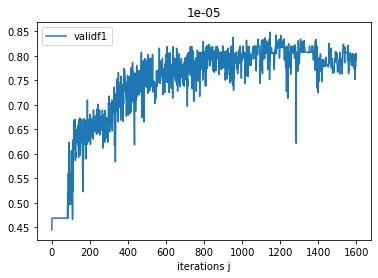

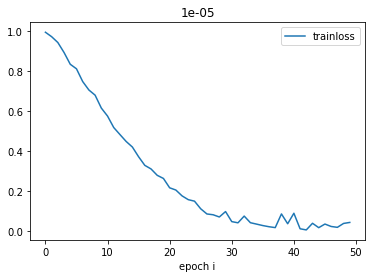

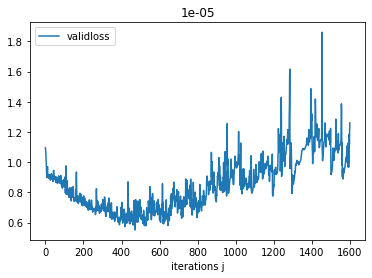

trainloss   mean:0.29     stdev:0.31
trainacc   mean:88.13     stdev:13.92
trainf1   mean:0.86     stdev:0.17
validloss   mean:0.86     stdev:0.18
validacc   mean:75.84     stdev:5.99
validf1   mean:0.74     stdev:0.09

epoch15 of iteration 231 has the smallest valid loss of 0.5510666296841242

epoch36 has the highest f1 score of 0.8483923483923484


In [10]:
#ALEXNET lr1
torch.manual_seed(1)
model=alexnet(num_classes=3)
model_path=r"C:\Users\Admin\Documents\FYP\ALEXNET"
if not os.path.exists(model_path):
    os.mkdir(model_path)
os.chdir(model_path)
training(model,lr1)


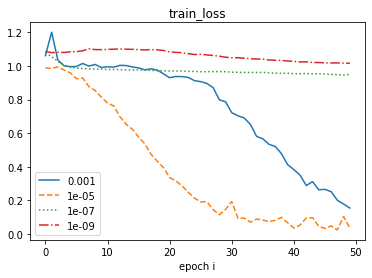

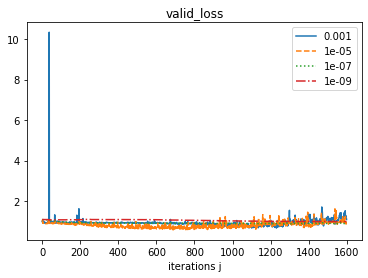

In [11]:
#Print loss graph for different lr
os.chdir(r"C:\Users\Admin\Documents\FYP")

trainloss1=np.load(r'RESNET18\{}_results\{}_trainloss.npy'.format(lr1,lr1))
validloss1=np.load(r'RESNET18\{}_results\{}_validloss.npy'.format(lr1,lr1))

trainloss2=np.load(r'RESNET18\{}_results\{}_trainloss.npy'.format(lr2,lr2))
validloss2=np.load(r'RESNET18\{}_results\{}_validloss.npy'.format(lr2,lr2))

trainloss3=np.load(r'RESNET18\{}_results\{}_trainloss.npy'.format(lr3,lr3))
validloss3=np.load(r'RESNET18\{}_results\{}_validloss.npy'.format(lr3,lr3))

trainloss0=np.load(r'RESNET18\{}_results\{}_trainloss.npy'.format(lr0,lr0))
validloss0=np.load(r'RESNET18\{}_results\{}_validloss.npy'.format(lr0,lr0))

lrgraph(1,'train_loss',trainloss0,trainloss1,trainloss2,trainloss3, lr0,lr1,lr2,lr3, "epoch i")
lrgraph(2,'valid_loss',validloss0,validloss1,validloss2,validloss3, lr0,lr1,lr2,lr3, "iterations j")

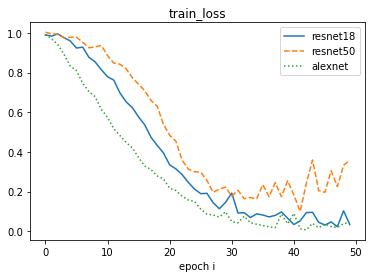

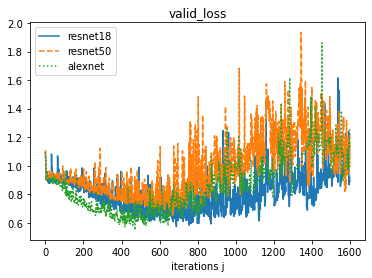

In [12]:
#Print loss graph for different models

resnet18_t_loss = np.load(r"RESNET18\{}_results\{}_trainloss.npy".format(lr1,lr1))
resnet18_v_loss = np.load(r"RESNET18\{}_results\{}_validloss.npy".format(lr1,lr1))

restnet50_t_loss = np.load(r"RESNET50\{}_results\{}_trainloss.npy".format(lr1,lr1))
restnet50_v_loss = np.load(r"RESNET50\{}_results\{}_validloss.npy".format(lr1,lr1))

alexnet_t_loss =np.load(r"ALEXNET\{}_results\{}_trainloss.npy".format(lr1,lr1))
alexnet_v_loss =np.load(r"ALEXNET\{}_results\{}_validloss.npy".format(lr1,lr1))

modelgraph(1,"train_loss",resnet18_t_loss,restnet50_t_loss,alexnet_t_loss,
                                    "resnet18","resnet50","alexnet",
                                    "epoch i")
modelgraph(2,"valid_loss",resnet18_v_loss,restnet50_v_loss,alexnet_v_loss,
                                    "resnet18","resnet50","alexnet",
                                    "iterations j")

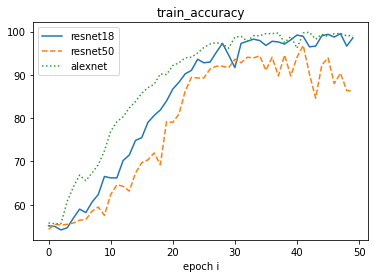

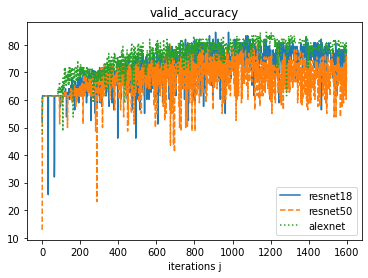

In [13]:
#Print accuracy graph for different models
resnet18_t_acc = np.load(r"RESNET18\{}_results\{}_trainacc.npy".format(lr1,lr1))
resnet18_v_acc = np.load(r"RESNET18\{}_results\{}_validacc.npy".format(lr1,lr1))

restnet50_t_acc = np.load(r"RESNET50\{}_results\{}_trainacc.npy".format(lr1,lr1))
restnet50_v_acc = np.load(r"RESNET50\{}_results\{}_validacc.npy".format(lr1,lr1))

alexnet_t_acc =np.load(r"ALEXNET\{}_results\{}_trainacc.npy".format(lr1,lr1))
alexnet_v_acc =np.load(r"ALEXNET\{}_results\{}_validacc.npy".format(lr1,lr1))

modelgraph(1,"train_accuracy",resnet18_t_acc,restnet50_t_acc,alexnet_t_acc,
                                    "resnet18","resnet50","alexnet",
                                    "epoch i")
modelgraph(2,"valid_accuracy",resnet18_v_acc,restnet50_v_acc,alexnet_v_acc,
                                    "resnet18","resnet50","alexnet",
                                    "iterations j")

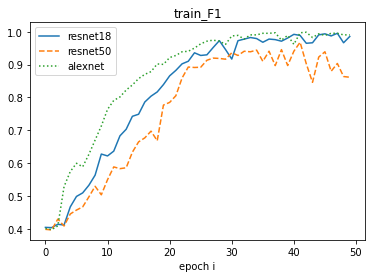

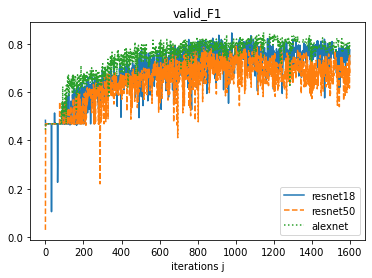

In [14]:
#Print F1 graph for different models
resnet18_t_f1 = np.load(r"RESNET18\{}_results\{}_trainf1.npy".format(lr1,lr1))
resnet18_v_f1 = np.load(r"RESNET18\{}_results\{}_validf1.npy".format(lr1,lr1))

restnet50_t_f1 = np.load(r"RESNET50\{}_results\{}_trainf1.npy".format(lr1,lr1))
restnet50_v_f1 = np.load(r"RESNET50\{}_results\{}_validf1.npy".format(lr1,lr1))

alexnet_t_f1 =np.load(r"ALEXNET\{}_results\{}_trainf1.npy".format(lr1,lr1))
alexnet_v_f1 =np.load(r"ALEXNET\{}_results\{}_validf1.npy".format(lr1,lr1))

modelgraph(1,"train_F1",resnet18_t_f1,restnet50_t_f1,alexnet_t_f1,
                                    "resnet18","resnet50","alexnet",
                                    "epoch i")
modelgraph(2,"valid_F1",resnet18_v_f1,restnet50_v_f1,alexnet_v_f1,
                                    "resnet18","resnet50","alexnet",
                                    "iterations j")
